## Update QC metrics for blur to better catch poor quality images

After extraction of QC metrics, we find optimal thresholds for blur per platemap layout for all channels for only one side of the distribution.
More negative represents blur, so we only need one threshold to catch these conditions.
More positive/close to 0 looks to represent empty images but we don't need to catch that condition.

The goal is to minimize over-correction. We plot each metric per channel and manually define the best cut-off.

In [1]:
import pandas as pd
import pathlib
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set JSON file output path
json_dir = pathlib.Path("./blur_thresholds")
json_dir.mkdir(parents=True, exist_ok=True)

# Load in all Image.csv files from qc_results
qc_results_path = pathlib.Path("qc_results")
csv_files = qc_results_path.rglob("Image.csv")

# Directory for saving plots
qc_plot_dir = pathlib.Path("./qc_plots")
qc_plot_dir.mkdir(parents=True, exist_ok=True)

# Read and concatenate all CSV files into a single DataFrame, adding layout column
data_frames = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)

    # Normalize and fix Metadata_Plate based on folder name
    df["Metadata_Plate"] = csv_file.parent.name.strip()

    # Add layout information for the plate (second parent folder name)
    df["layout"] = csv_file.parent.parent.name
    data_frames.append(df)

qc_df = pd.concat(data_frames, ignore_index=True)

# Assert that each layout has exactly 4 unique plate IDs
layout_plate_counts = qc_df.groupby("layout")["Metadata_Plate"].nunique()
bad_layouts = layout_plate_counts[layout_plate_counts != 4]
if not bad_layouts.empty:
    raise ValueError(
        f"The following layouts do not have exactly 4 plate IDs:\n{bad_layouts}"
    )

# Print summary information
print(f"Concatenated DataFrame shape: {qc_df.shape}")
print(f"Unique layouts: {qc_df['layout'].unique()}")
print(f"Number of unique Metadata_Plate IDs: {qc_df['Metadata_Plate'].nunique()}")

Concatenated DataFrame shape: (63800, 101)
Unique layouts: ['platemap_11' 'platemap_9' 'platemap_3' 'platemap_7' 'platemap_10'
 'platemap_4' 'platemap_1' 'platemap_6' 'platemap_5' 'platemap_8'
 'platemap_2']
Number of unique Metadata_Plate IDs: 44


In [3]:
def validate_and_save_blur_thresholds(
    qc_df,
    layout_name,
    channels=None,
    thresholds=None,
    json_dir=pathlib.Path("."),
    qc_plot_dir=None,
    show_plot=True,
    palette=None,
):
    """
    Plot PowerLogLogSlope distributions per channel for a given layout and save thresholds
    to a per-layout JSON file. Optionally save plots to a QC plot directory.

    Parameters
    ----------
    qc_df : pd.DataFrame
        QC DataFrame containing 'layout' and 'Metadata_Plate' columns.
    layout_name : str
        Layout to filter and plot.
    channels : list of str, optional
        Channels to plot. Defaults to ["OrigActin", "OrigDNA", "OrigER", "OrigMito", "OrigPM"].
    thresholds : dict, optional
        Dictionary of thresholds per channel. Will be saved to JSON.
    json_dir : pathlib.Path, optional
        Directory to save JSON. Defaults to current directory.
    qc_plot_dir : pathlib.Path, optional
        Directory to save QC plots. If None, plots are not saved.
    show_plot : bool, optional
        Whether to display the plot.
    palette : list, optional
        Colors for each plate. Defaults to seaborn tab10 palette.
    """
    if channels is None:
        channels = ["OrigActin", "OrigDNA", "OrigER", "OrigMito", "OrigPM"]

    # Filter QC DataFrame for the layout
    filtered_qc_df = qc_df[qc_df["layout"] == layout_name]

    # Set palette if not provided
    n_plates = filtered_qc_df["Metadata_Plate"].nunique()
    if palette is None:
        palette = sns.color_palette("tab10", n_colors=n_plates)

    # Plot KDE distributions per channel
    fig, axes = plt.subplots(1, len(channels), figsize=(15, 4), sharey=True)
    for ax, channel in zip(axes, channels):
        col = f"ImageQuality_PowerLogLogSlope_{channel}"
        for color, (plate, plate_df) in zip(
            palette, filtered_qc_df.groupby("Metadata_Plate")
        ):
            sns.kdeplot(plate_df[col], ax=ax, color=color)
        # Plot threshold if provided
        if thresholds and channel in thresholds:
            ax.axvline(thresholds[channel], color="red", linestyle="--", linewidth=1.5)
        ax.set_title(channel)
        ax.set_xlabel("PowerLogLogSlope")
        ax.set_yticks([])

    plt.tight_layout()

    # Optionally save plot
    if qc_plot_dir is not None:
        qc_plot_dir = pathlib.Path(qc_plot_dir)
        qc_plot_dir.mkdir(parents=True, exist_ok=True)
        plot_path = qc_plot_dir / layout_name / "blur_thresholds_distributions.png"
        fig.savefig(plot_path, dpi=300, bbox_inches="tight")
        print(f"Saved QC plot for {layout_name} to {plot_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)

    # Save thresholds to a JSON file specific for this layout
    json_path = pathlib.Path(json_dir) / f"blur_thresholds_{layout_name}.json"
    to_save = thresholds if thresholds else {}
    with open(json_path, "w") as f:
        json.dump(to_save, f, indent=4)

    print(f"Saved thresholds for {layout_name} to {json_path}")

Based on the distributions, we can manually determine optimal cutoffs where we can see the tail of the normal distribution occur.
  
We visualize these thresholds below on the plot to validate.

Saved QC plot for platemap_1 to qc_plots/platemap_1/blur_thresholds_distributions.png


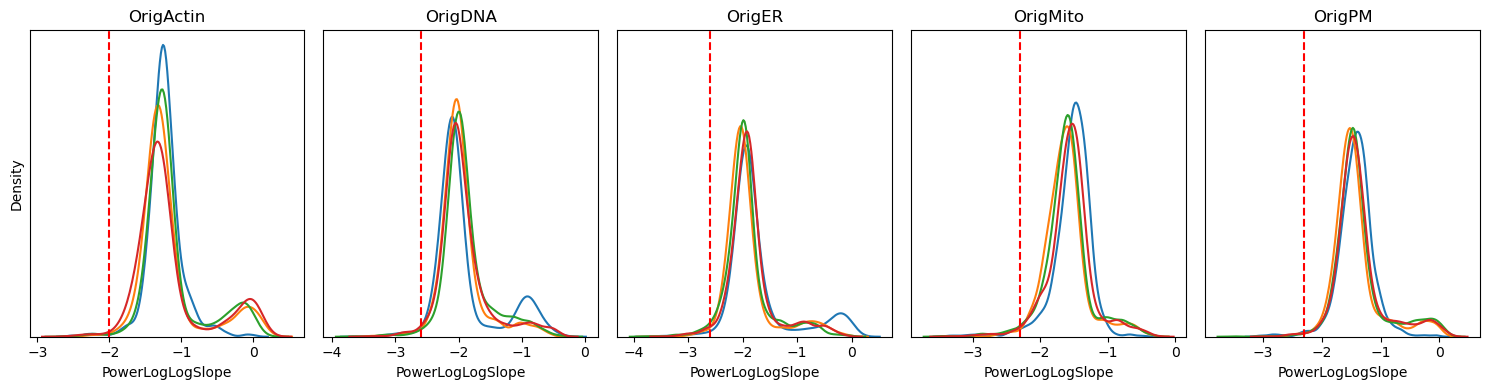

Saved thresholds for platemap_1 to blur_thresholds/blur_thresholds_platemap_1.json


In [4]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_1"
layout_1_blur_thresholds = {
    "OrigActin": -2,
    "OrigDNA": -2.6,
    "OrigER": -2.6,
    "OrigMito": -2.3,
    "OrigPM": -2.3,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_1_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_2 to qc_plots/platemap_2/blur_thresholds_distributions.png


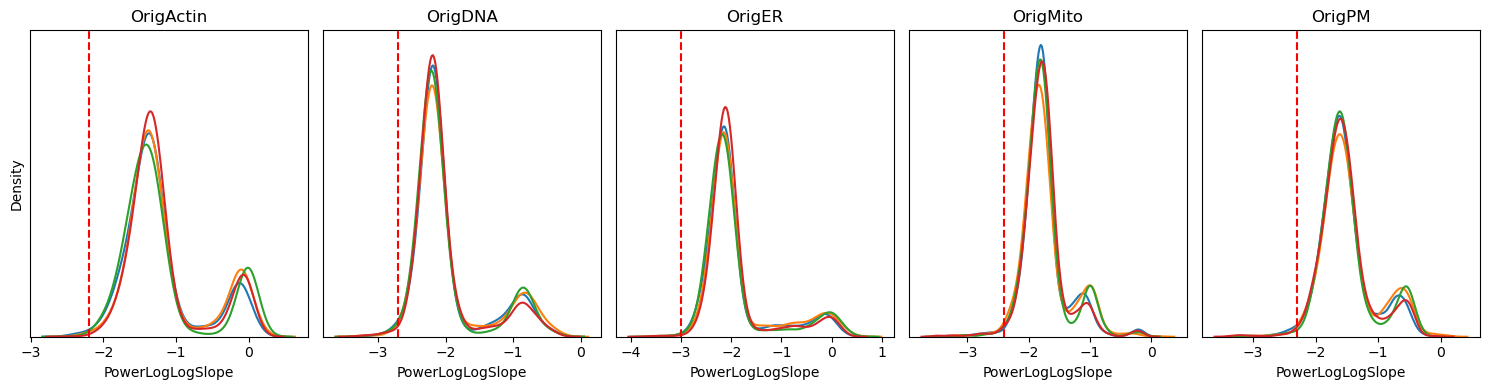

Saved thresholds for platemap_2 to blur_thresholds/blur_thresholds_platemap_2.json


In [5]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_2"
layout_2_blur_thresholds = {
    "OrigActin": -2.2,
    "OrigDNA": -2.7,
    "OrigER": -3,
    "OrigMito": -2.4,
    "OrigPM": -2.3,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_2_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_3 to qc_plots/platemap_3/blur_thresholds_distributions.png


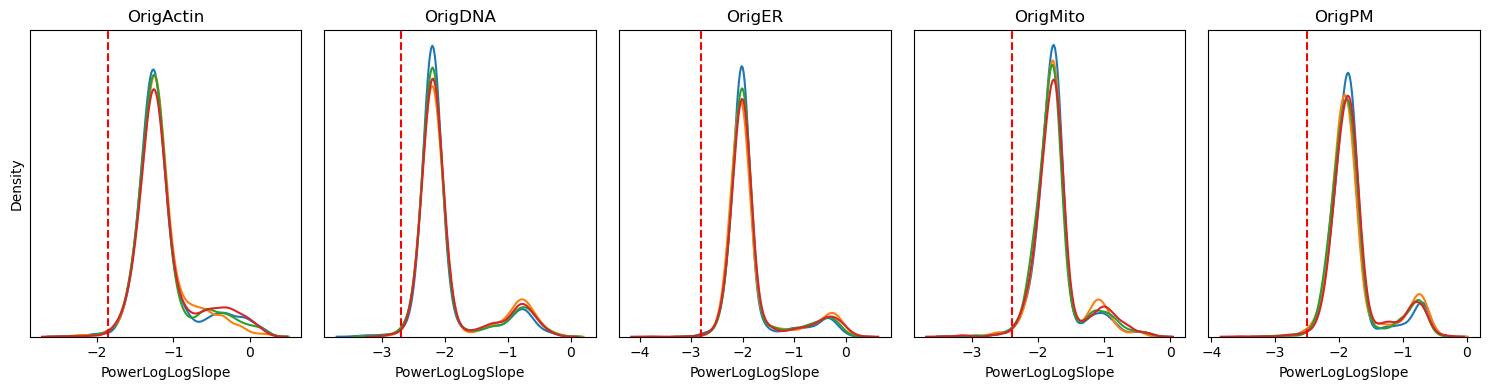

Saved thresholds for platemap_3 to blur_thresholds/blur_thresholds_platemap_3.json


In [6]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_3"
layout_3_blur_thresholds = {
    "OrigActin": -1.85,
    "OrigDNA": -2.7,
    "OrigER": -2.8,
    "OrigMito": -2.4,
    "OrigPM": -2.5,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_3_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_4 to qc_plots/platemap_4/blur_thresholds_distributions.png


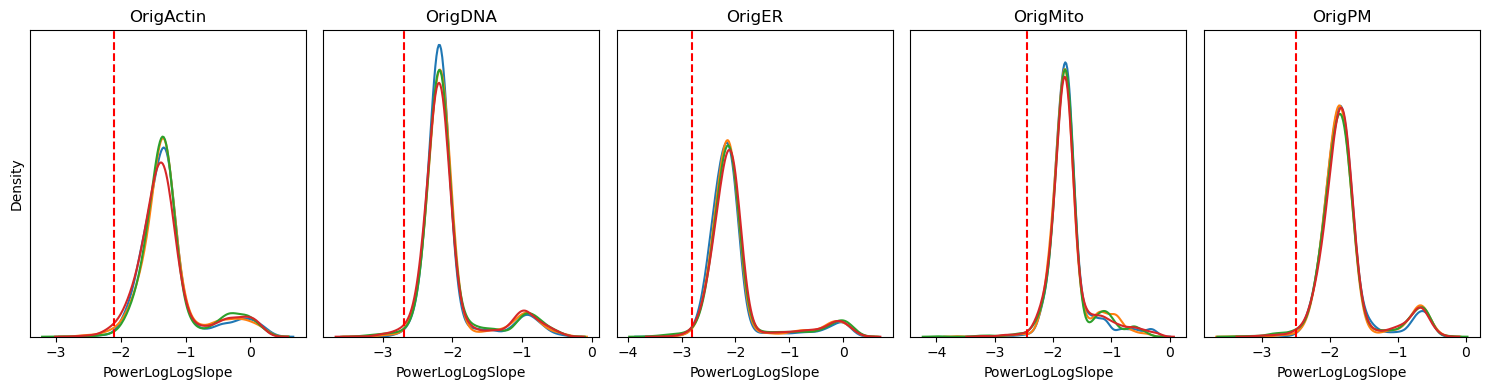

Saved thresholds for platemap_4 to blur_thresholds/blur_thresholds_platemap_4.json


In [7]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_4"
layout_4_blur_thresholds = {
    "OrigActin": -2.1,
    "OrigDNA": -2.7,
    "OrigER": -2.8,
    "OrigMito": -2.45,
    "OrigPM": -2.5,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_4_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_5 to qc_plots/platemap_5/blur_thresholds_distributions.png


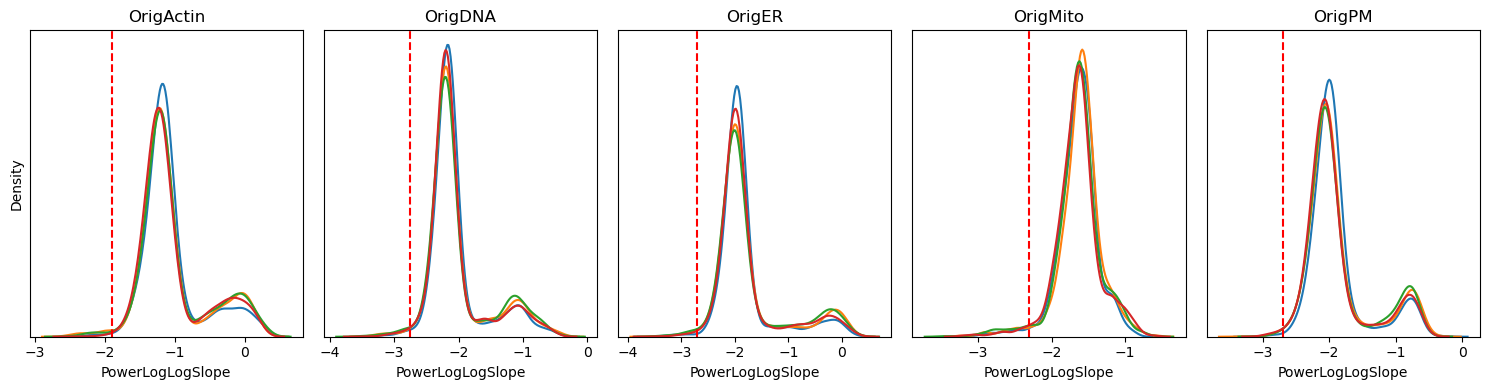

Saved thresholds for platemap_5 to blur_thresholds/blur_thresholds_platemap_5.json


In [8]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_5"
layout_5_blur_thresholds = {
    "OrigActin": -1.9,
    "OrigDNA": -2.75,
    "OrigER": -2.7,
    "OrigMito": -2.3,
    "OrigPM": -2.7,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_5_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_6 to qc_plots/platemap_6/blur_thresholds_distributions.png


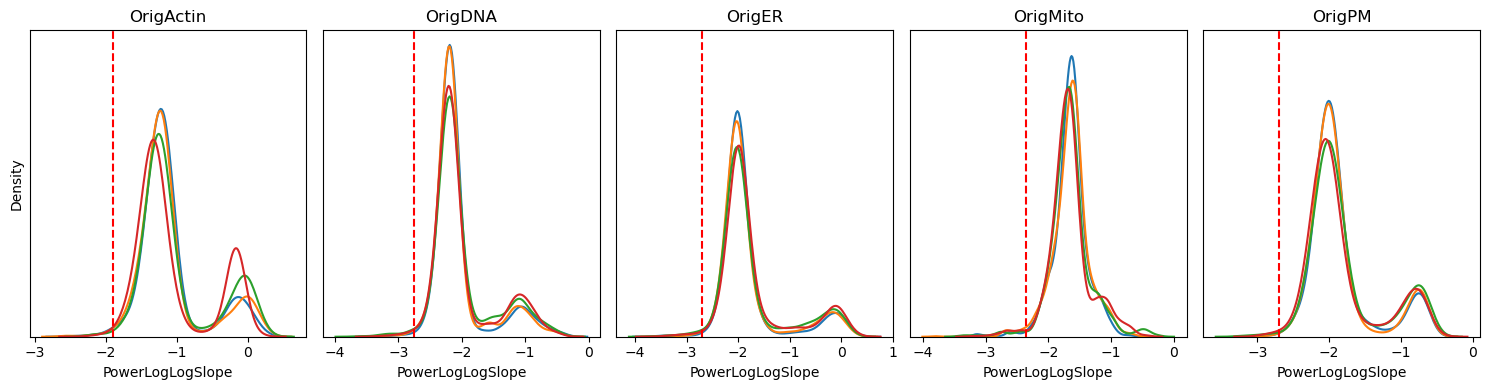

Saved thresholds for platemap_6 to blur_thresholds/blur_thresholds_platemap_6.json


In [9]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_6"
layout_6_blur_thresholds = {
    "OrigActin": -1.9,
    "OrigDNA": -2.75,
    "OrigER": -2.7,
    "OrigMito": -2.35,
    "OrigPM": -2.7,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_6_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_7 to qc_plots/platemap_7/blur_thresholds_distributions.png


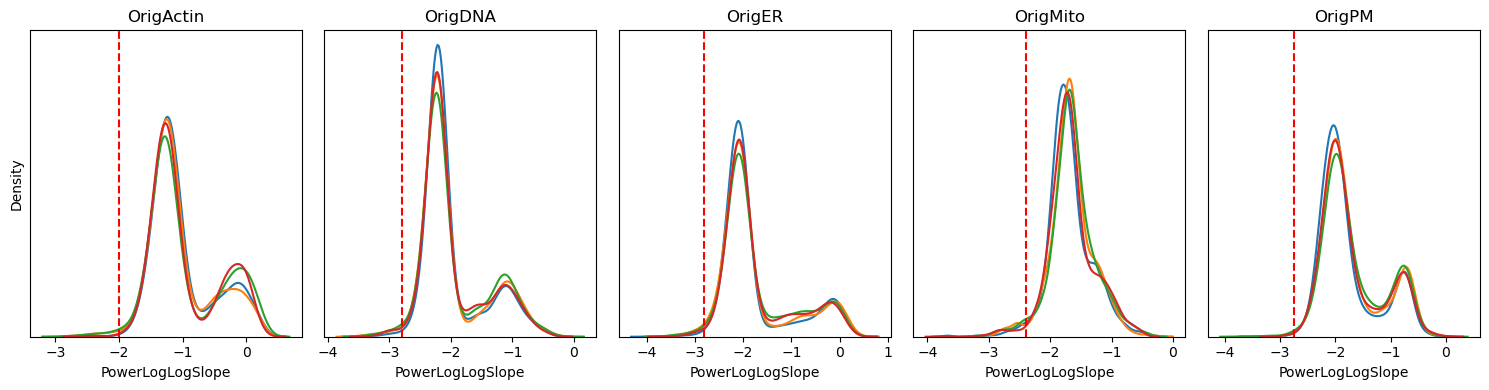

Saved thresholds for platemap_7 to blur_thresholds/blur_thresholds_platemap_7.json


In [10]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_7"
layout_7_blur_thresholds = {
    "OrigActin": -2,
    "OrigDNA": -2.8,
    "OrigER": -2.8,
    "OrigMito": -2.4,
    "OrigPM": -2.75,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_7_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_8 to qc_plots/platemap_8/blur_thresholds_distributions.png


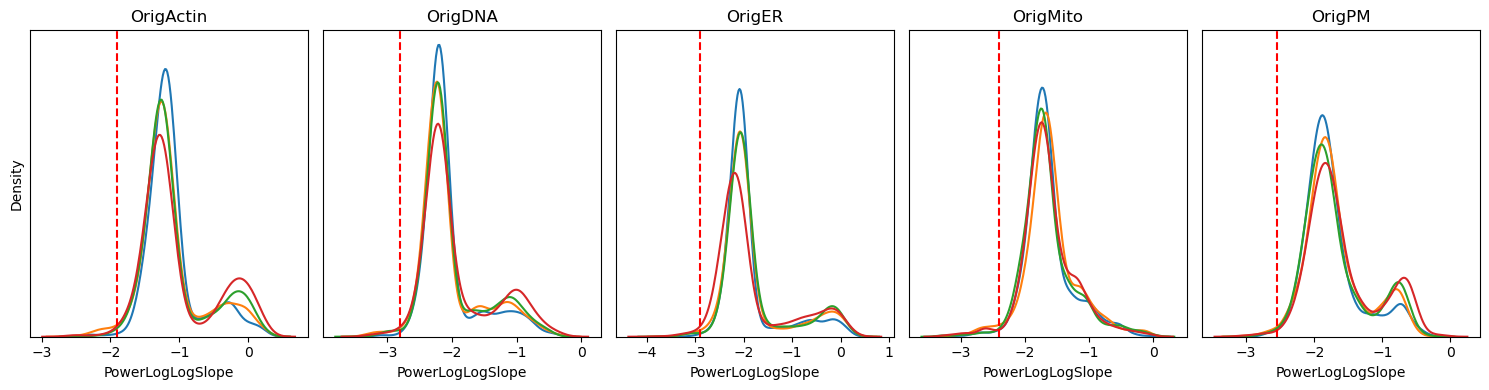

Saved thresholds for platemap_8 to blur_thresholds/blur_thresholds_platemap_8.json


In [11]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_8"
layout_8_blur_thresholds = {
    "OrigActin": -1.9,
    "OrigDNA": -2.8,
    "OrigER": -2.9,
    "OrigMito": -2.4,
    "OrigPM": -2.55,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_8_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_9 to qc_plots/platemap_9/blur_thresholds_distributions.png


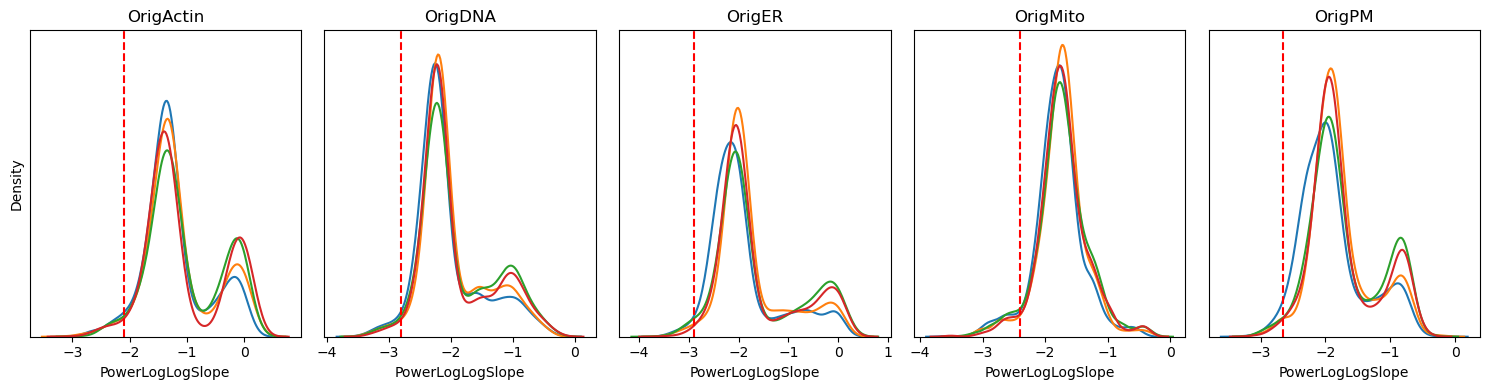

Saved thresholds for platemap_9 to blur_thresholds/blur_thresholds_platemap_9.json


In [12]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_9"
layout_9_blur_thresholds = {
    "OrigActin": -2.1,
    "OrigDNA": -2.8,
    "OrigER": -2.9,
    "OrigMito": -2.4,
    "OrigPM": -2.65,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_9_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_10 to qc_plots/platemap_10/blur_thresholds_distributions.png


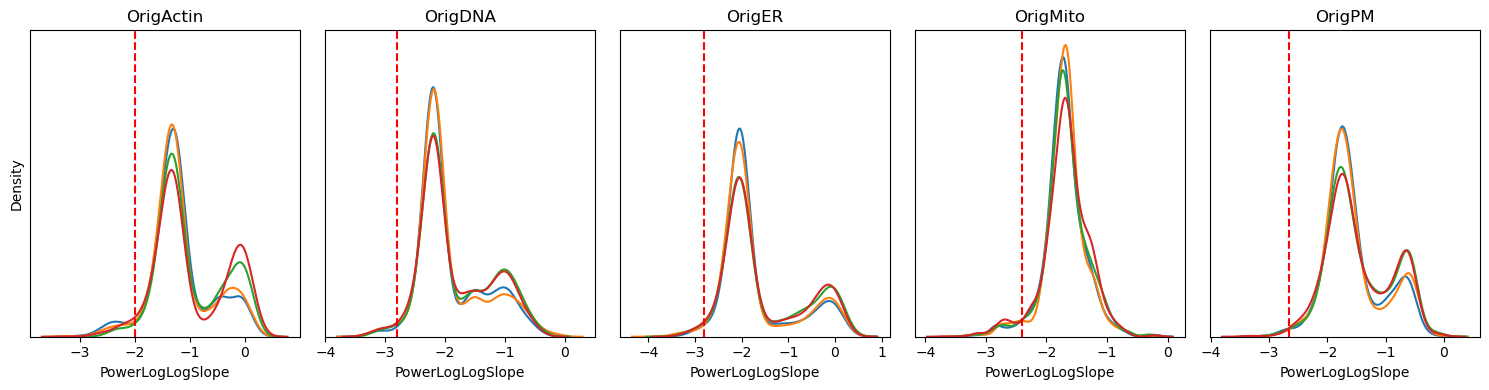

Saved thresholds for platemap_10 to blur_thresholds/blur_thresholds_platemap_10.json


In [13]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_10"
layout_10_blur_thresholds = {
    "OrigActin": -2.0,
    "OrigDNA": -2.8,
    "OrigER": -2.8,
    "OrigMito": -2.4,
    "OrigPM": -2.65,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_10_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)

Saved QC plot for platemap_11 to qc_plots/platemap_11/blur_thresholds_distributions.png


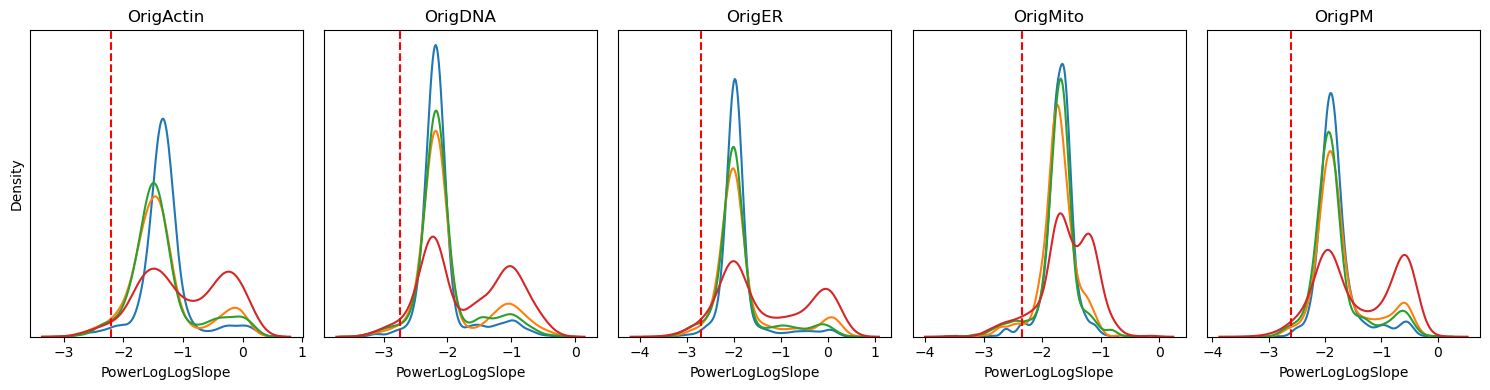

Saved thresholds for platemap_11 to blur_thresholds/blur_thresholds_platemap_11.json


In [14]:
# Example: set thresholds and save for one layout using the helper function
layout_name = "platemap_11"
layout_11_blur_thresholds = {
    "OrigActin": -2.2,
    "OrigDNA": -2.75,
    "OrigER": -2.7,
    "OrigMito": -2.35,
    "OrigPM": -2.6,
}

# Run function to validate thresholds
validate_and_save_blur_thresholds(
    qc_df=qc_df,
    layout_name=layout_name,
    thresholds=layout_11_blur_thresholds,
    json_dir=json_dir,
    show_plot=True,  # set to False if you don't want to display the plots
    qc_plot_dir=qc_plot_dir,
)